In [16]:
!pip3 install tqdm

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
     |████████████████████████████████| 76 kB 5.9 MB/s             
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


In [13]:
# 기본
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import joblib
import math
# from sklearn.externals import joblib 

# 시계열
# from fbprophet import Prophet
from datetime import datetime as dt
# from statsmodels.tsa.arima_model import ARIMA
# from dateutil.relativedelta import relativedelta
# from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing

# 회귀분석
# from sklearn.svm import SVR
# from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestClassifier #,RandomForestRegressor
# from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso #,ElasticNet, LogisticRegression
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Deep Neural Network
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import time

# 설정
%matplotlib inline
pd.options.display.max_columns = 400
pd.options.display.float_format = '{:.5f}'.format
from IPython.display import Image
plt.rc('font', family='NanumGothic') # For Windows


In [17]:
from tqdm import tqdm
from dateutil.relativedelta import relativedelta

EAE

In [18]:
def mae(prediction, correct):
    score = abs(np.array(correct) - np.array(prediction)).mean()
    return score

mae_scorer = make_scorer(mae)
mae_scorer

make_scorer(mae)

RMSE 평균 제곱근 오차




In [19]:
def rmse(prediction, correct):
    return math.sqrt((np.array(correct) - np.array(prediction) ** 2).mean())

## 데이터 넣기

In [21]:
df_train = pd.read_csv('./datasets/funda_train.csv')
df_sub = pd.read_csv('./datasets/submission.csv')

In [22]:
df_train.shape, df_sub.shape

((6556613, 9), (1967, 2))

In [23]:
df_train['transacted_date'] = pd.to_datetime(df_train['transacted_date'])

In [24]:
#환불데이터
df_train.insert(6,'refund',0)
df_train.loc[df_train.amount < 0 ,'refund']= 1

데이터 삭제 region,type_of_business

In [25]:
df_train.drop(['region','type_of_business', 'transacted_time'], axis =1, inplace=True)

레이블 인코딩

In [26]:
from sklearn.preprocessing import LabelEncoder

In [27]:
class_le = LabelEncoder()
df_train_e = class_le.fit_transform(df_train['card_company'].values)
df_train_e

array([1, 7, 2, ..., 0, 3, 2])

In [28]:
df_train['card_company'] = df_train_e

In [29]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6556613 entries, 0 to 6556612
Data columns (total 7 columns):
 #   Column            Dtype         
---  ------            -----         
 0   store_id          int64         
 1   card_id           int64         
 2   card_company      int64         
 3   transacted_date   datetime64[ns]
 4   installment_term  int64         
 5   refund            int64         
 6   amount            float64       
dtypes: datetime64[ns](1), float64(1), int64(5)
memory usage: 350.2 MB


## 환불 데이터 노이즈 제거거

In [30]:
def refund_remove(df):
    refund=df[df['amount']<0]
    non_refund=df[df['amount']>0]
    remove_data=pd.DataFrame()
    
    for i in tqdm(df.store_id.unique()):
        divided_data=non_refund[non_refund['store_id']==i] ##non_refund 스토어 데이터를 스토어별로 나눔
        divided_data2=refund[refund['store_id']==i] ##refund 스토어 데이터를 나눔 스토어별로 나눔
        
        for neg in divided_data2.to_records()[:]: ##환불데이터를 차례대로 검사
            refund_store=neg['store_id']
            refund_id=neg['card_id'] ## 환불 카드 아이디
            refund_datetime=neg['transacted_date'] ## 환불 시간
            refund_amount=abs(neg['amount']) ## 환불액 절대값을 씌움
                
            ##환불시간 이전의 데이터중 카드이이디와 환불액이 같은 후보 리스트를 뽑는다.
            refund_pay_list=divided_data[divided_data['transacted_date']<=refund_datetime]
            refund_pay_list=refund_pay_list[refund_pay_list['card_id']==refund_id]
            refund_pay_list=refund_pay_list[refund_pay_list['amount']==refund_amount]
                
                
            #후보리스트가 있으면,카드아이디, 환불액이 같으면서 가장 최근시간을 제거
            if(len(refund_pay_list)!=0):
                refund_datetime=max(refund_pay_list['transacted_date']) ##가장 최근 시간을 구한다
                remove=divided_data[divided_data['transacted_date']==refund_datetime] ##가장 최근시간
                remove=remove[remove['card_id']==refund_id] ##환불 카드 아이디
                remove=remove[remove['amount']==refund_amount] ##환불액
                divided_data=divided_data.drop(index=remove.index) #인덱스를 통해 제거
                    
        ##제거한데이터를 데이터프레임에 추가한다.
        remove_data=pd.concat([remove_data,divided_data],axis=0)
    
    return remove_data

In [31]:
df_train = refund_remove(df_train)

 10%|▉         | 195/1967 [00:25<04:34,  6.47it/s]

In [ ]:
df_train.to_csv("./datasets/funda_train_remove_refund.csv", index=False)

In [ ]:
df_train.head()

In [ ]:
df_train = pd.read_csv('./datasets/funda_train_remove_refund.csv')

In [ ]:
df_train['transacted_date'] = pd.to_datetime(df_train['transacted_date'])
df_train = df_train.set_index('transacted_date')

In [ ]:
df_train.head()

,store_id,card_id,card_company,installment_term,refund,amount
transacted_date,,,,,,
2016-06-01,0,0,1,0,0,1857.14286
2016-06-01,0,1,7,0,0,857.14286
2016-06-01,0,2,2,0,0,2000.00000
2016-06-01,0,3,0,0,0,7857.14286
2016-06-02,0,4,2,0,0,2000.00000


## 일 데이터로 축소

In [ ]:
def resample_day(train_df):
    df_day = pd.DataFrame()
    
    for i in train_df['store_id'].unique():
        df_num = train_df[train_df['store_id']==i]

        # 'card_id'의 일별 counting을 통해 일 거래 횟수 확인
        # resample 함수의 rule='d'인 경우 일별 그룹이 가능해지고, count 함수를 통해 unique 값별로 빈도수 생성
        count_cols = df_num['card_id'].resample(rule='d').count().rename('num_of_pay')
        
        # 'card_id' value count가 2보다 크면 단골로 판단하고 단골 방문 횟수 확인
        revisit_idx = df_num['card_id'].value_counts().reset_index().query('card_id > 2')['index'].values
        revisit_ct = df_num[df_num['card_id'].isin(revisit_idx)]['card_id'].resample(rule='d').count().rename('num_of_revisit')
        

        # 할부 개월수와 매출액은 일단위로 합
        sum_cols = df_num[[ 'refund', 'installment_term',  'amount']].resample(rule='d').sum()
        
        df_num_day = pd.concat([count_cols, revisit_ct, sum_cols], axis=1)
        
        # 매장 id, 지역, 업종 분류 추가
        df_num_day.insert(0, 'store_id', i)
        # df_num_day.insert(4, 'region', df_num[df_num['store_id']==i]['region'].unique()[0])
        # df_num_day.insert(5, 'type_of_business', df_num[df_num['store_id']==i]['type_of_business'].unique()[0])
        
        df_day = pd.concat([df_day, df_num_day], axis=0)
        
    df_day.insert(1, 'day_of_week', df_day.index.dayofweek) #df_day가 일별로 묶여index에 들어가 있음
    df_day.insert(2, 'business_day', df_day['day_of_week'].replace({0:1, 2:1, 3:1, 4:1, 5:0, 6:0}).values)
    df_day['num_of_revisit'].fillna(0, inplace=True)
    
        
    return df_day
def resample_month(frame_day):
    sum_cols = ['num_of_pay', 'num_of_revisit', 'refund', 'installment_term', 'amount']

    df_monthly = pd.DataFrame()

    for i in frame_day.store_id.unique():
        df_set = frame_day[frame_day.store_id == i]
        
        # nan값이 발생하는 경우를 없애기 위해 이전, 이후 달에 대한 정보를 추가한 후 제거
        prev_date = pd.date_range(start=(df_set.index[0] - relativedelta(months=1)), end=(df_set.index[0] - relativedelta(months=1)))
        add_date = pd.date_range(start=(df_set.index[-1] + relativedelta(months=1)), end=(df_set.index[-1] + relativedelta(months=1)))
        df_set = pd.concat([pd.DataFrame(index=prev_date), df_set, pd.DataFrame(index=add_date)], axis=0)

        df_set.loc[dt.strftime(df_set.index[0], '%Y-%m'), :] = 1
        df_set.loc[dt.strftime(df_set.index[-1], '%Y-%m'), :] = 1

        tot_day = df_set[df_set.amount != 0].day_of_week.resample(rule='m').count().rename('real_tot_day')
        business = df_set[df_set.amount != 0].business_day.resample(rule='m').sum().rename('real_business_day')

        business = business.drop([business.index[0], business.index[-1]], axis=0)
        tot_day = tot_day.drop([tot_day.index[0], tot_day.index[-1]], axis=0)
        df_set = df_set.drop([df_set.index[0], df_set.index[-1]], axis=0)

        df = pd.concat([tot_day, business, df_set[sum_cols].resample(rule='m').sum()], axis=1)

        df.insert(0, 'store_id', i)
        # df.insert(6, 'region', df_set.region.values[0])
        # df.insert(7, 'type_of_business', df_set.type_of_business.values[0])

        df_monthly = pd.concat([df_monthly, df], axis=0)
   
    return df_monthly

In [ ]:
%%time
df_day = resample_day(df_train)

CPU times: user 3min 27s, sys: 10.4 s, total: 3min 37s
Wall time: 3min 28s


In [ ]:
%%time
df_month = resample_month(df_day)

CPU times: user 59 s, sys: 832 ms, total: 59.8 s
Wall time: 56.2 s


In [ ]:
df_day.isnull().sum()

store_id            0
day_of_week         0
business_day        0
num_of_pay          0
num_of_revisit      0
refund              0
installment_term    0
amount              0
dtype: int64

In [ ]:
df_day.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1837015 entries, 2016-06-01 to 2019-02-28
Data columns (total 8 columns):
 #   Column            Dtype  
---  ------            -----  
 0   store_id          int64  
 1   day_of_week       int64  
 2   business_day      int64  
 3   num_of_pay        int64  
 4   num_of_revisit    float64
 5   refund            int64  
 6   installment_term  int64  
 7   amount            float64
dtypes: float64(2), int64(6)
memory usage: 126.1 MB


In [ ]:
#df_month 저장
df_month.to_csv("/content/drive/MyDrive/해커톤/funda_train_month.csv", index=True)

NameError: ignored

In [ ]:
df_month

,store_id,real_tot_day,real_business_day,num_of_pay,num_of_revisit,refund,installment_term,amount
2016-06-30,0,25,17.00000,142.00000,74.00000,0.00000,7.00000,738428.57143
2016-07-31,0,26,16.00000,178.00000,105.00000,0.00000,24.00000,1005000.00000
2016-08-31,0,24,16.00000,168.00000,94.00000,0.00000,69.00000,869714.28571
2016-09-30,0,25,19.00000,160.00000,103.00000,0.00000,15.00000,897857.14286
2016-10-31,0,26,16.00000,165.00000,115.00000,0.00000,9.00000,835428.57143
...,...,...,...,...,...,...,...,...
2018-10-31,2136,31,23.00000,332.00000,77.00000,0.00000,0.00000,2012214.28571
2018-11-30,2136,28,20.00000,347.00000,78.00000,0.00000,0.00000,2127642.85714
2018-12-31,2136,31,21.00000,396.00000,101.00000,0.00000,0.00000,2411571.42857
2019-01-31,2136,31,23.00000,294.00000,71.00000,0.00000,3.00000,1867785.71429


# 시작~

In [6]:
#불러오기기
df_month = pd.read_csv('/content/drive/MyDrive/해커톤/funda_train_month.csv')

In [7]:
df_month.columns

Index(['Unnamed: 0', 'store_id', 'real_tot_day', 'real_business_day',
       'num_of_pay', 'num_of_revisit', 'refund', 'installment_term', 'amount'],
      dtype='object')

In [8]:
df_month.rename(columns = {'Unnamed: 0' : 'transacted_date'}, inplace = True)

In [9]:
df_month['transacted_date'] = pd.to_datetime(df_month['transacted_date'])
df_month = df_month.set_index('transacted_date')

In [10]:
df_month.tail()

,store_id,real_tot_day,real_business_day,num_of_pay,num_of_revisit,refund,installment_term,amount
transacted_date,,,,,,,,
2018-10-31,2136,31,23.00000,332.00000,77.00000,0.00000,0.00000,2012214.28571
2018-11-30,2136,28,20.00000,347.00000,78.00000,0.00000,0.00000,2127642.85714
2018-12-31,2136,31,21.00000,396.00000,101.00000,0.00000,0.00000,2411571.42857
2019-01-31,2136,31,23.00000,294.00000,71.00000,0.00000,3.00000,1867785.71429
2019-02-28,2136,28,20.00000,365.00000,66.00000,0.00000,0.00000,2221857.14286


In [11]:
# df_day = df_day.drop(df_day[df_day['amount']<0].index ,axis=0)

In [12]:
# df_month = df_month.drop(df_month[df_month['amount']<0].index ,axis=0)

In [13]:
df_month[df_month['amount']<0]

,store_id,real_tot_day,real_business_day,num_of_pay,num_of_revisit,refund,installment_term,amount
transacted_date,,,,,,,,


In [14]:
from sklearn.metrics import make_scorer

def rmsle(predicted_values, actual_values, convertExp=True):

    if convertExp:
        predicted_values = np.exp(predicted_values),
        actual_values = np.exp(actual_values)
        
    # 넘파이로 배열 형태로 바꿔준다.
    predicted_values = np.array(predicted_values)
    actual_values = np.array(actual_values)
    
    # 예측값과 실제 값에 1을 더하고 로그를 씌워준다.
    # 값이 0일 수도 있어서 로그를 취했을 때 마이너스 무한대가 될 수도 있기 때문에 1을 더해 줌
    # 로그를 씌워주는 것은 정규분포로 만들어주기 위해
    log_predict = np.log(predicted_values + 1)
    log_actual = np.log(actual_values + 1)
    
    # 위에서 계산한 예측값에서 실제값을 빼주고 제곱을 해준다.
    difference = log_predict - log_actual
    difference = np.square(difference)
    
    # 평균을 낸다.
    mean_difference = difference.mean()
    
    # 다시 루트를 씌운다.
    score = np.sqrt(mean_difference)
    
    return score
rmsle_scorer = make_scorer(rmsle)
rmsle_scorer

make_scorer(rmsle)

###데이터 나누기

In [15]:
X =df_month.loc[:,'store_id':'num_of_revisit']
y =df_month.loc[:,'amount']

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.33, random_state = 100)

In [16]:
# 타입변경
# df_day = df_day.astype('float')
# df_day = df_day.astypes({'amount':'float'})

머신러닝 적용

##LinearRegression

In [ ]:
model = LinearRegression()
# 모델을 학습시킨다.
y_train_log = np.log1p(y_train)
model.fit(X_train, y_train_log)

# 예측하고 정확도를 평가한다.
preds = model.predict(X_train)

print ("RMSLE Value For Linear Regression: ",
       rmsle(np.exp(y_train_log),np.exp(preds), False))

RMSLE Value For Linear Regression:  1.5022249723572598


##Ridge

In [ ]:
from sklearn import metrics
ridge_m_ = Ridge()
ridge_params_ = { 'max_iter':[1000,2000,3000],'alpha':[0.01, 0.1, 1, 2, 3, 4, 10, 30,100,200,300,400,800,900,1000]}
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)
grid_ridge_m = GridSearchCV( ridge_m_,
                          ridge_params_,
                          scoring = rmsle_scorer,
                          cv=5)

y_train_log = np.log1p(y_train)
grid_ridge_m.fit( X_train, y_train_log )
preds = grid_ridge_m.predict(X_train)
print (grid_ridge_m.best_params_)
print ("RMSLE Value For Ridge Regression: ", rmsle(np.exp(y_train_log),np.exp(preds), False))

df = pd.DataFrame(grid_ridge_m.cv_results_)

{'alpha': 1000, 'max_iter': 1000}
RMSLE Value For Ridge Regression:  1.5628128040450626


##lasso

In [ ]:
lasso_m_ = Lasso()

alpha  = 1/np.array([0.1, 1, 2, 3, 4, 10, 30,100,200,300,400,800,900,1000])
lasso_params_ = { 'max_iter':[3000],'alpha':alpha}

grid_lasso_m = GridSearchCV( lasso_m_,lasso_params_,scoring = rmsle_scorer,cv=5)
y_train_log = np.log1p(y_train)
grid_lasso_m.fit( X_train , y_train_log )
preds = grid_lasso_m.predict(X_train)
print (grid_lasso_m.best_params_)
print ("RMSLE Value For Lasso Regression: ",rmsle(np.exp(y_train_log),np.exp(preds),False))

# df = pd.DataFrame(grid_lasso_m.cv_results_)
# df["alpha"] = df["params"].apply(lambda x:x["alpha"])
# df["rmsle"] = df["mean_test_score"].apply(lambda x:-x)

# df[["alpha", "rmsle"]].head()

{'alpha': 10.0, 'max_iter': 3000}
RMSLE Value For Lasso Regression:  1.65422464497394


##Ensemble Models -랜덤포레스트

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rfModel = RandomForestRegressor(n_estimators=100)

y_train_log = np.log1p(y_train)
rfModel.fit(X_train, y_train_log)

preds = rfModel.predict(X_train)
score = rmsle(np.exp(y_train_log),np.exp(preds),False)
print ("RMSLE Value For Random Forest: ",score)

RMSLE Value For Random Forest:  0.2681916486623197


##Ensemble Model - Gradient Boost

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
gbm = GradientBoostingRegressor(n_estimators=200, alpha=0.01);

y_train_log = np.log1p(y_train)
gbm.fit(X_train, y_train_log)

preds = gbm.predict(X_train)
score = rmsle(np.exp(y_train_log),np.exp(preds),False)
print ("RMSLE Value For Gradient Boost: ", score)

RMSLE Value For Gradient Boost:  0.8216324601901901


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


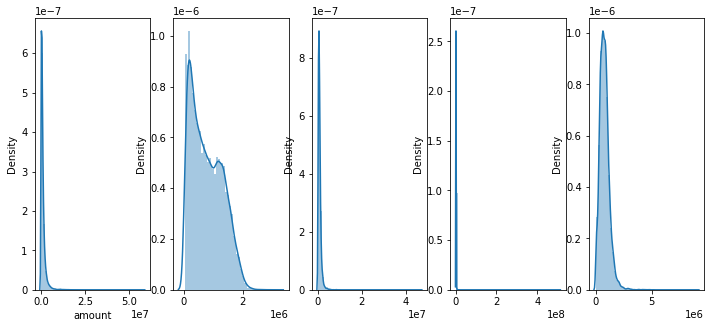

In [ ]:
#gbm 예측 그래프
predsTest = model.predict(X_test)
predsTest_rf = rfModel.predict(X_test)
predsTest_grm = grid_lasso_m.predict(X_test)
predsTest_gbm = gbm.predict(X_test)
fig,(ax1,ax2,ax3,ax4,ax5)= plt.subplots(ncols=5)
fig.set_size_inches(12,5)
sns.distplot(y_train,ax=ax1,bins=50)
sns.distplot(np.exp(predsTest),ax=ax2,bins=50)
sns.distplot(np.exp(predsTest_rf),ax=ax3,bins=50)
sns.distplot(np.exp(predsTest_grm),ax=ax4,bins=50)
sns.distplot(np.exp(predsTest_gbm),ax=ax5,bins=50)

In [ ]:
X_test

,store_id,real_tot_day,real_business_day,num_of_pay,num_of_revisit
transacted_date,,,,,
2017-07-31,2002,22,14.00000,34.00000,1.00000
2017-12-31,729,18,15.00000,31.00000,12.00000
2017-09-30,979,11,10.00000,15.00000,10.00000
2017-07-31,1151,26,20.00000,94.00000,37.00000
2018-05-31,905,13,11.00000,27.00000,24.00000
...,...,...,...,...,...
2018-12-31,486,13,7.00000,19.00000,4.00000
2016-10-31,1529,31,21.00000,226.00000,58.00000
2017-11-30,1836,16,10.00000,29.00000,4.00000


In [ ]:
compare = pd.DataFrame()
compare['store_id'] = X_test['store_id']
compare['y_true'] = y_test
compare['y_predict_li'] = np.exp(predsTest)
compare['y_predict_rf'] = np.exp(predsTest_rf)
compare['y_predict_grm'] = np.exp(predsTest_grm)
compare['y_predict_gbm'] = np.exp(predsTest_gbm)

In [ ]:
compare.sort_index(ascending=True)

,store_id,y_true,y_predict_li,y_predict_rf,y_predict_grm,y_predict_gbm
transacted_date,,,,,,
2016-06-30,1328,1318071.42857,1023963.09729,921412.10690,563623.69489,756980.94884
2016-06-30,1778,1198642.85714,1088338.87106,900769.80079,529995.42716,813962.13680
2016-06-30,426,1264571.42857,995186.07255,651800.10023,467045.91087,864136.68782
2016-06-30,1774,82285.71429,460261.31986,239387.71880,411724.62634,503019.69128
2016-06-30,1,137214.28571,1488927.12065,194603.82171,693392.73647,176905.89422
...,...,...,...,...,...,...
2019-02-28,2094,118714.28571,238709.32213,414685.00041,363310.62004,384521.93689
2019-02-28,1719,450000.00000,226133.16264,378192.91428,345305.92199,380588.97237
2019-02-28,1662,109857.14286,108910.11246,517798.55281,343368.83209,219310.60012


그래프

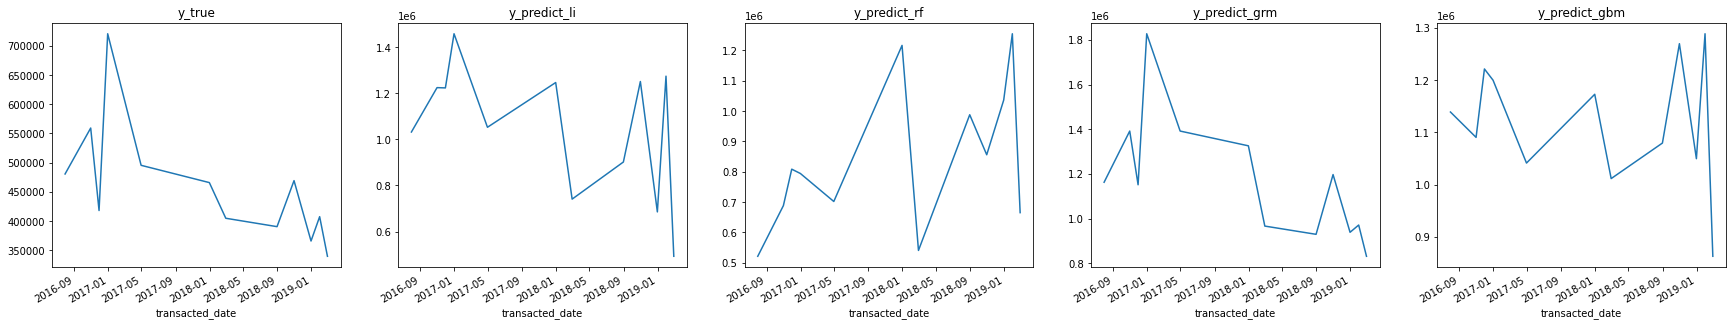

In [ ]:
fig,(ax1,ax2,ax3,ax4,ax5)= plt.subplots(ncols=5)
fig.set_size_inches(30,5)
srore_check = (compare['store_id']==1400)
compare[srore_check]['y_true'].plot(title = 'y_true' , ax=ax1)
compare[srore_check]['y_predict_li'].plot(title = 'y_predict_li', ax=ax2)
compare[srore_check]['y_predict_rf'].plot(title = 'y_predict_rf', ax=ax3)
compare[srore_check]['y_predict_grm'].plot(title = 'y_predict_grm', ax=ax4)
compare[srore_check]['y_predict_gbm'].plot(title = 'y_predict_gbm', ax=ax5)

In [ ]:
df_month.shape

(60833, 8)

# 시계열 분석

## LSTM

## RNN

원하는 기간 예측

In [ ]:
date_idx = pd.date_range('2019-03-01', '2019-05-31')
date_idx

DatetimeIndex(['2019-03-01', '2019-03-02', '2019-03-03', '2019-03-04',
               '2019-03-05', '2019-03-06', '2019-03-07', '2019-03-08',
               '2019-03-09', '2019-03-10', '2019-03-11', '2019-03-12',
               '2019-03-13', '2019-03-14', '2019-03-15', '2019-03-16',
               '2019-03-17', '2019-03-18', '2019-03-19', '2019-03-20',
               '2019-03-21', '2019-03-22', '2019-03-23', '2019-03-24',
               '2019-03-25', '2019-03-26', '2019-03-27', '2019-03-28',
               '2019-03-29', '2019-03-30', '2019-03-31', '2019-04-01',
               '2019-04-02', '2019-04-03', '2019-04-04', '2019-04-05',
               '2019-04-06', '2019-04-07', '2019-04-08', '2019-04-09',
               '2019-04-10', '2019-04-11', '2019-04-12', '2019-04-13',
               '2019-04-14', '2019-04-15', '2019-04-16', '2019-04-17',
               '2019-04-18', '2019-04-19', '2019-04-20', '2019-04-21',
               '2019-04-22', '2019-04-23', '2019-04-24', '2019-04-25',
      

In [ ]:
#df_sub

df_sub["amount"] = np.exp(predsTest_rf)

print(df_sub.shape)
df_sub.head()

ValueError: ignored